# Bio-Argo match-ups
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 21, 2025

We have upwards of 33k bbp700 and 10k chl-a points for the global bio-Argo data. The goal is to get the Rrs data, all bands, for each of these. However, with so many points we need to be careful with memory. Just opening the meta-data for all the Rrs files, 500+ days since March 2024, will eat up a lot of memory.

**What do we do?**

1. When we open the PACE Rrs files, we create `ds` with `chunks{}` so that dask knows the chunk structure and will not try to load the whole file.
2. We compute the vector of indices for the Argo points and use `ds.vindex([vector_i, vector_j)`. That will load only the needed chunks.
3. We work through the files in batches rather than one massive for loop. This will keep the memory from exploding on us as we open files.


## Load the Argo profile data

This is the lat/lon/time data for every profile we have from Mar 2024 to Nov 2025. We will use this information to find matching Rrs, Kd, and chlor_a data from PACE.

In [27]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="LATITUDE"; df_lon_name="LONGITUDE"; df_time_name="TIME"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/argo_monthly_nc/"
url = f"{base_url}argo_profiles_index.parquet"
argo_chl_df = pd.read_parquet(url)
len(argo_chl_df)

15792

## Load custom functions

In [3]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

# Workflow to process one PACE file

Assume:

* The files are for a regular grid, i.e. level 3 data
* The files do not have a time coordinate. This is how the PACE level 3 daily and 8-day files are currently structured.
* We are looking at a variable, like Rrs, that has a 3rd dimension of wavelength or similar. Usually called wavelength or wavelength_3d. So the dims are (lat, lon, 3rd dim)
* `time_coverage_start` and `time_coverage_end` exist as attributes in the files.
* `ds[ds_vec_name]` is a 1D coordinate aligned with the last dimension of ds_var_name.

Process Steps:

1.  Subset our Argo dataframe to only those rows within in the  time window covered by the cloud-hosted xarray dataset (`ds`). Let's call that `df_day`
2.  Get the lat/lon indices of `ds` that correspond to the lat/lon rows in `df_day`. These indices will look like `[0, 3, 6]` and `[0, 10, 15]` corresponding to index pairs, like `(3, 10)` corresponding to the lat/lon pair in a row of `df_day`.
3.  Do a fast point retrieval from `ds`. `ds` is cloud optimized (chunked) file and we only want to the chunks that we need. We do not need to load all the chunks. I/O of cloud-hosted data is the slow part so don't touch more of the data than you need to.
4. Build a dataframe with the predictor variables that we want from `ds`.

In [31]:
## The function to process one file is in ml_utils.py
help(mu.one_file_matches)

Help on function one_file_matches in module ml_utils:

one_file_matches(f: 'earthaccess.store.EarthAccessFile', df: pandas.core.frame.DataFrame, ds_lat_name: str = 'lat', ds_lon_name: str = 'lon', ds_time_name: str = 'time', ds_vec_name: Optional[str] = 'wavelength', ds_var_name: str = 'Rrs', ds_vec_sel=None, df_lat_name: str = 'lat', df_lon_name: str = 'lon', df_time_name: str = 'time') -> Tuple[Optional[pandas.core.frame.DataFrame], Optional[pandas.core.frame.DataFrame]]
        Match Argo point observations to a single PACE L2/L3 file and extract
        colocated satellite values and metadata.
    
        Parameters
        ----------
        f : file-like object
            An earthaccess/open file-like handle for a single PACE granule
            (as returned by `earthaccess.open`). This object is passed directly
            to `xr.open_dataset` to read the granule.
        df : pandas.DataFrame
            A DataFrame containing Argo observations. Must include columns for
     

## Run through the PACE files in batches

Just in case something hangs.

### Workflow

* Create a function to get all matches for one PACE file `one_file_matches()`
* Create a function to run a batch of PACE files `run_batch()`
* Do a for loop over our batches and run `run_batch()` on each
* Gather results into one file

We will run for all PACE files that we have. Later when we match to the Argo profiles, we can choose the best PACE data, e.g. only use NRT data if that is all that is available.

### `run_batch()` function

* Run `mu.one_file_matches()` on each file
* Save results from the batch to a file in case the process crashes
* Later we will reconstruct from the batch files. The files are small.

In [4]:
%%time
from datetime import datetime

def run_batch(
    results, df, 
    ds_vec_name="wavelength", ds_var_name="Rrs", ds_vec_sel=None,
    df_time_name="TIME", df_lat_name="LATITUDE", df_lon_name="LONGITUDE"
):
    """
    Run a batch of PACE files (results) and return PACE variables for lat/lon/time rows in a
    dataframe.

    Parameters
    ----------
    results : earthaccess results object as returned by `earthaccess.search`). 
    
    df : A pandas DataFrame containing Argo observations. Must include columns for
        time, latitude, longitude.

    ds_vec_name : str or None, optional
        Name of the spectral dimension in the PACE dataset (e.g. "wavelength").
        If not None, matched satellite spectra are returned with one column per
        wavelength. If None, only a single variable is extracted.

    ds_vec_sel : value or None, optional
        Value of the spectral dimension in the PACE dataset (e.g. "wavelength")
        to select. If None, matched satellite spectra are returned with one column per
        wavelength. If given, only a single variable is extracted for that value.

    ds_var_name : str, optional
        Name of the variable to extract from the PACE dataset
        (e.g. "Rrs" or "chlor_a").

    df_lat_name, df_lon_name, df_time_name : str, optional
        Column names in `df` for latitude, longitude, and time.
    """

    # Make sure to refresh fileset to minimize the chance that the token expires before we are done
    # this for loop consumes about 6Gb of RAM
    fileset = earthaccess.open(results, pqdm_kwargs={"disable": True} );
    
    df_plus = []
    for i, f in enumerate(fileset):
        df_record, pts = mu.one_file_matches(
            f, df, 
            ds_vec_name=ds_vec_name, ds_var_name=ds_var_name, ds_vec_sel=ds_vec_sel,
            df_time_name=df_time_name, df_lat_name=df_lat_name, df_lon_name=df_lon_name)
        if df_record is None or len(df_record) == 0: 
            print(f"Skipped day {i} no data in df")
            continue
        # error check
        if len(df_record) != len(pts):
            raise ValueError(f"Row mismatch: df_record={len(df_record)}, pts={len(pts)}")
    
        # left "concat": keep df_record rows, add pts columns by position
        df_record_plus = pd.concat(
            [ 
                df_record.reset_index(drop=True), 
                pts.reset_index(drop=True),
            ], axis=1,)
        df_plus.append(df_record_plus)
    if not len(df_plus) == 0:
        df_plus = pd.concat(df_plus, ignore_index=True)
    return df_plus

CPU times: user 12 μs, sys: 1e+03 ns, total: 13 μs
Wall time: 16.5 μs


## Get the Rrs Level 3 PACE Data

In [4]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
df = argo_chl_df
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
rrs_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS_NRT",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
results = rrs_results + rrs_results_nrt
print(f"{len(results)} days of PACE data")

712 days of PACE data


Check the format of individuals day data.

In [51]:
import xarray as xr
fileset = earthaccess.open(results[0:1], pqdm_kwargs={"disable": True} )
ds = xr.open_dataset(
        fileset[0],
        chunks={}
    )
ds

<xarray.Dataset> Size: 26GB
Dimensions:     (lat: 4320, lon: 8640, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB dask.array<chunksize=(16, 1024, 8), meta=np.ndarray>
    palette     (rgb, eightbitcolor) uint8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3861548
    data_minimum:                      -0.009998
    data_maximum:                      0.092371605

In [67]:
%%time
# test that run_batch() works
df = argo_chl_df
res=run_batch(results[0:1], df)
res.head()

CPU times: user 1.37 s, sys: 143 ms, total: 1.51 s
Wall time: 3.35 s


,profile_id,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,pace_Rrs_file,pace_Rrs_t_start,pace_Rrs_t_end,pace_Rrs_lat,...,pace_Rrs_706,pace_Rrs_707,pace_Rrs_708,pace_Rrs_709,pace_Rrs_711,pace_Rrs_712,pace_Rrs_713,pace_Rrs_714,pace_Rrs_717,pace_Rrs_719
0,4903485_0033,4903485,33,2024-03-05 01:16:05.000000000,29.082600,-17.213600,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,29.062498,...,0.000218,0.000218,0.000224,0.000214,0.000214,0.000196,0.000174,0.000166,0.00016,0.000214
1,2902882_0077,2902882,77,2024-03-05 02:08:10.000000000,25.111515,148.146488,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,25.104164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5906304_0116,5906304,116,2024-03-05 06:58:45.000999936,-34.152200,-165.736500,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,-34.145836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2903856_0019,2903856,19,2024-03-05 08:16:05.000999936,0.673300,-165.453300,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,0.687497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7901028_0055,7901028,55,2024-03-05 11:32:39.019000064,69.673916,4.204859,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,69.687500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Run through all the files by batches

This takes about 4 hours for Rrs.

In [5]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "CHLA"
results = results
df = argo_chl_df
ds_var = "Rrs"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, df)  # returns a DataFrame

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")


Batch 1: 10 files: 03:12:40
  -> Saved 164 rows to data/matchups/CHLA_matchups_Rrs_batch_001.parquet
Batch 2: 10 files: 03:14:14
  -> Saved 175 rows to data/matchups/CHLA_matchups_Rrs_batch_002.parquet
Batch 3: 10 files: 03:15:52
  -> Saved 190 rows to data/matchups/CHLA_matchups_Rrs_batch_003.parquet
Batch 4: 10 files: 03:17:35
  -> Saved 187 rows to data/matchups/CHLA_matchups_Rrs_batch_004.parquet
Batch 5: 10 files: 03:19:25
  -> Saved 187 rows to data/matchups/CHLA_matchups_Rrs_batch_005.parquet
Batch 6: 10 files: 03:21:18
  -> Saved 176 rows to data/matchups/CHLA_matchups_Rrs_batch_006.parquet
Batch 7: 10 files: 03:23:05
  -> Saved 183 rows to data/matchups/CHLA_matchups_Rrs_batch_007.parquet
Batch 8: 10 files: 03:24:46
  -> Saved 206 rows to data/matchups/CHLA_matchups_Rrs_batch_008.parquet
Batch 9: 10 files: 03:26:31
  -> Saved 206 rows to data/matchups/CHLA_matchups_Rrs_batch_009.parquet
Batch 10: 10 files: 03:28:05
  -> Saved 196 rows to data/matchups/CHLA_matchups_Rrs_batch_0

In [5]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

results_dir = Path("_temp_data/matchups")
var = "CHLA"
ds_var = "Rrs"

batch_files = sorted(results_dir.glob(f"{var}_matchups_{ds_var}_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"{results_dir}/{var}_argo_{ds_var}_all.parquet", index=False)


In [6]:
print(f"Total rows: {len(df_all)}")

Total rows: 18119


### Same idea for PACE CHLA data


In [26]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

In [28]:
# Add on chla to the clean parquet
import pandas as pd
import earthaccess
import xarray as xr

# Get PACE CHL data
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
chl_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = (argo_chl_df.TIME.min(), argo_chl_df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
chl_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL_NRT",
    temporal = (argo_chl_df.TIME.min(), argo_chl_df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
results = chl_results + chl_results_nrt
print(f"{len(results)} days of PACE data")

712 days of PACE data


In [9]:
%%time
# test that it works
res = run_batch(results[0:1], argo_chl_df, ds_vec_name=None, ds_var_name="chlor_a")
res.head()

CPU times: user 1.39 s, sys: 240 ms, total: 1.63 s
Wall time: 7.29 s


,profile_id,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,pace_chlor_a_file,pace_chlor_a_t_start,pace_chlor_a_t_end,pace_chlor_a_lat,pace_chlor_a_lon,pace_chlor_a
0,4903485_0033,4903485,33,2024-03-05 01:16:05.000000000,29.082600,-17.213600,PACE_OCI.20240305.L3m.DAY.CHL.V3_1.chlor_a.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,29.062498,-17.229162,0.265202
1,2902882_0077,2902882,77,2024-03-05 02:08:10.000000000,25.111515,148.146488,PACE_OCI.20240305.L3m.DAY.CHL.V3_1.chlor_a.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,25.104164,148.145844,NaN
2,5906304_0116,5906304,116,2024-03-05 06:58:45.000999936,-34.152200,-165.736500,PACE_OCI.20240305.L3m.DAY.CHL.V3_1.chlor_a.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,-34.145836,-165.729172,NaN
3,2903856_0019,2903856,19,2024-03-05 08:16:05.000999936,0.673300,-165.453300,PACE_OCI.20240305.L3m.DAY.CHL.V3_1.chlor_a.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,0.687497,-165.437500,NaN
4,7901028_0055,7901028,55,2024-03-05 11:32:39.019000064,69.673916,4.204859,PACE_OCI.20240305.L3m.DAY.CHL.V3_1.chlor_a.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,69.687500,4.187506,NaN


In [10]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "CHLA"
results = results
df = argo_chl_df
ds_var = "chlor_a"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, df, ds_vec_name=None, ds_var_name="chlor_a")

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")

Batch 1: 10 files: 16:01:45
  -> Saved 164 rows to data/matchups/CHLA_matchups_chlor_a_batch_001.parquet
Batch 2: 10 files: 16:01:50
  -> Saved 175 rows to data/matchups/CHLA_matchups_chlor_a_batch_002.parquet
Batch 3: 10 files: 16:01:56
  -> Saved 190 rows to data/matchups/CHLA_matchups_chlor_a_batch_003.parquet
Batch 4: 10 files: 16:02:01
  -> Saved 187 rows to data/matchups/CHLA_matchups_chlor_a_batch_004.parquet
Batch 5: 10 files: 16:02:06
  -> Saved 187 rows to data/matchups/CHLA_matchups_chlor_a_batch_005.parquet
Batch 6: 10 files: 16:02:12
  -> Saved 176 rows to data/matchups/CHLA_matchups_chlor_a_batch_006.parquet
Batch 7: 10 files: 16:02:17
  -> Saved 183 rows to data/matchups/CHLA_matchups_chlor_a_batch_007.parquet
Batch 8: 10 files: 16:02:22
  -> Saved 206 rows to data/matchups/CHLA_matchups_chlor_a_batch_008.parquet
Batch 9: 10 files: 16:02:28
  -> Saved 206 rows to data/matchups/CHLA_matchups_chlor_a_batch_009.parquet
Batch 10: 10 files: 16:02:33
  -> Saved 196 rows to dat

In [11]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

results_dir = Path("_temp_data/matchups")
var = "CHLA"
ds_var = "chlor_a"

batch_files = sorted(results_dir.glob(f"{var}_matchups_{ds_var}_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"{results_dir}/{var}_argo_{ds_var}_all.parquet", index=False)


### Same idea with the PACE Kd490 data


In [12]:
# Add on chla to the clean parquet
import pandas as pd
import earthaccess
import xarray as xr

# Get PACE CHL data
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
kd_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = (argo_chl_df.TIME.min(), argo_chl_df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
kd_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD_NRT",
    temporal = (argo_chl_df.TIME.min(), argo_chl_df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
results = kd_results + kd_results_nrt
print(f"{len(results)} days of PACE data")

712 days of PACE data


In [13]:
%%time
# test that it works
res = run_batch(results[0:1], argo_chl_df, ds_var_name="Kd", ds_vec_sel=490.0)
res.head()

CPU times: user 466 ms, sys: 56.5 ms, total: 523 ms
Wall time: 7.12 s


,profile_id,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,pace_Kd_file,pace_Kd_t_start,pace_Kd_t_end,pace_Kd_lat,pace_Kd_lon,pace_Kd_490
0,4903485_0033,4903485,33,2024-03-05 01:16:05.000000000,29.082600,-17.213600,PACE_OCI.20240305.L3m.DAY.KD.V3_1.Kd.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,29.062498,-17.229162,0.071
1,2902882_0077,2902882,77,2024-03-05 02:08:10.000000000,25.111515,148.146488,PACE_OCI.20240305.L3m.DAY.KD.V3_1.Kd.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,25.104164,148.145844,NaN
2,5906304_0116,5906304,116,2024-03-05 06:58:45.000999936,-34.152200,-165.736500,PACE_OCI.20240305.L3m.DAY.KD.V3_1.Kd.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,-34.145836,-165.729172,NaN
3,2903856_0019,2903856,19,2024-03-05 08:16:05.000999936,0.673300,-165.453300,PACE_OCI.20240305.L3m.DAY.KD.V3_1.Kd.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,0.687497,-165.437500,NaN
4,7901028_0055,7901028,55,2024-03-05 11:32:39.019000064,69.673916,4.204859,PACE_OCI.20240305.L3m.DAY.KD.V3_1.Kd.4km.nc,2024-03-05 00:08:58.225000+00:00,2024-03-06 02:07:24.895000+00:00,69.687500,4.187506,NaN


In [14]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "CHLA"
results = results
df = argo_chl_df
ds_var = "Kd"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, argo_chl_df, ds_var_name="Kd", ds_vec_sel=490.0)

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")

Batch 1: 10 files: 16:28:02
  -> Saved 164 rows to data/matchups/CHLA_matchups_Kd_batch_001.parquet
Batch 2: 10 files: 16:28:12
  -> Saved 175 rows to data/matchups/CHLA_matchups_Kd_batch_002.parquet
Batch 3: 10 files: 16:28:21
  -> Saved 190 rows to data/matchups/CHLA_matchups_Kd_batch_003.parquet
Batch 4: 10 files: 16:28:31
  -> Saved 187 rows to data/matchups/CHLA_matchups_Kd_batch_004.parquet
Batch 5: 10 files: 16:28:42
  -> Saved 187 rows to data/matchups/CHLA_matchups_Kd_batch_005.parquet
Batch 6: 10 files: 16:28:53
  -> Saved 176 rows to data/matchups/CHLA_matchups_Kd_batch_006.parquet
Batch 7: 10 files: 16:29:05
  -> Saved 183 rows to data/matchups/CHLA_matchups_Kd_batch_007.parquet
Batch 8: 10 files: 16:29:16
  -> Saved 206 rows to data/matchups/CHLA_matchups_Kd_batch_008.parquet
Batch 9: 10 files: 16:29:27
  -> Saved 206 rows to data/matchups/CHLA_matchups_Kd_batch_009.parquet
Batch 10: 10 files: 16:29:36
  -> Saved 196 rows to data/matchups/CHLA_matchups_Kd_batch_010.parquet

In [16]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

results_dir = Path("_temp_data/matchups")
var = "CHLA"
ds_var = "Kd"

batch_files = sorted(results_dir.glob(f"{var}_matchups_{ds_var}_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"{results_dir}/{var}_argo_{ds_var}_all.parquet", index=False)


## Merge all the PACE data into one parquet

This has PACE data only for profiles. `clean` has duplicates removed and rows with no Rrs removed. Saved to `CHLA_argo_Rrs_chlor_a_Kd.parquet`.

In [67]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd
import numpy as np

results_dir = Path("_temp_data/matchups")
var = "CHLA"

df_all_kd = pd.read_parquet(f"{results_dir}/{var}_argo_Kd_all.parquet")
df_all_chl = pd.read_parquet(f"{results_dir}/{var}_argo_chlor_a_all.parquet")
df_all_rrs = pd.read_parquet(f"{results_dir}/{var}_argo_Rrs_all.parquet")

# check 
n = 6
assert np.array_equal(
    df_all_chl.iloc[:, :n].values,
    df_all_rrs.iloc[:, :n].values
), "First 6 column values differ"

assert np.array_equal(
    df_all_kd.iloc[:, :n].values,
    df_all_rrs.iloc[:, :n].values
), "First 6 column values differ"
#n = 7:11
assert np.array_equal(
    df_all_chl.iloc[:, 7:11].values,
    df_all_rrs.iloc[:, 7:11].values
), "t/lat/lon values differ"
assert np.array_equal(
    df_all_kd.iloc[:, 7:11].values,
    df_all_rrs.iloc[:, 7:11].values
), "t/lat/lon values differ"

# columns to add
df_chl_extra = df_all_chl["pace_chlor_a"]
df_kd_extra = df_all_kd["pace_Kd_490"]
# Horizontal concat: rrs on the left, extras on the right
df_merged = pd.concat([df_all_rrs, df_chl_extra, df_kd_extra], axis=1)
df_merged.to_parquet(f"{resuls_dir}/{var}_argo_Rrs_chlor_a_Kd_all.parquet", index=False)

In [16]:
# Cleaned; no missing Rrs
# Duplicates replaced with the PACE data that is closest to TIME

from pathlib import Path
import pandas as pd
results_dir = Path("_temp_data/matchups")
var = "CHLA"

df_merged = pd.read_parquet(f"{results_dir}/{var}_argo_Rrs_chlor_a_Kd_all.parquet")
rrs_cols = [c for c in df_merged.columns if c.startswith("pace_Rrs_") and c[-1].isdigit()]
df_merged_clean = df_merged.dropna(subset=rrs_cols, how="all").reset_index(drop=True)

df = df_merged_clean

# Parse all times as UTC-aware datetimes
for col in ["TIME", "pace_Rrs_t_start", "pace_Rrs_t_end"]:
    df[col] = pd.to_datetime(df[col], utc=True)

# is file NRT
df["nrt"] = [("NRT" in f) for f in df["pace_Rrs_file"]]
idx = df.groupby("profile_id")["nrt"].idxmin()
df = df.loc[idx].drop(columns=["nrt"]).reset_index(drop=True)

# center of the PACE time window
df["pace_center"] = df["pace_Rrs_t_start"] + (
    df["pace_Rrs_t_end"] - df["pace_Rrs_t_start"]
) / 2

# 2. absolute time difference between profile TIME and window center
df["time_diff"] = (df["TIME"] - df["pace_center"]).abs()

# 3. for each profile_id, keep the row with smallest time_diff
idx = df.groupby("profile_id")["time_diff"].idxmin()

df_dedup = df.loc[idx].drop(columns=["pace_center", "time_diff"]).reset_index(drop=True)
df_dedup = df_dedup.sort_values(by="TIME").reset_index(drop=True)
df_dedup.to_parquet(f"{results_dir}/{var}_argo_Rss_chlor_a_Kd.parquet", index=False)

## Create the final parquet by merging the Argo and PACE data

All Bio-Argo profiles where there is Rrs data. If there are 2 PACE files that cover the time of an Argo profiles, which can happen if time is near midnight or there is delayed and NRT data, then choose the delayed data (higher QC) first. If duplicates still exist, chose the PACE data that is closest in time to the Argo data.

In [17]:
# merge the Argo and PACE data. Only profiles with Rrs data
from pathlib import Path
results_dir = Path("_temp_data/matchups")
var = "CHLA"

import pandas as pd
out_path = f"data/{var}_argo_profiles.parquet"
profiles = pd.read_parquet(out_path)
profiles["TIME"] = pd.to_datetime(profiles["TIME"], utc=True)
# cleaned version; no dups; must have Rrs
out_path = f"{results_dir}/{var}_argo_Rrs_chlor_a_Kd_all.parquet"
pace = pd.read_parquet(out_path)
print(len(profiles))
print(len(pace))

15833
18119


In [18]:
# Cleaned; no missing Rrs
# Duplicates replaced with the PACE data that is closest to TIME

import pandas as pd
from pathlib import Path
results_dir = Path("_temp_data/matchups")
var = "CHLA"

df_merged = pd.read_parquet(f"{results_dir}/{var}_argo_Rrs_chlor_a_Kd_all.parquet")

df = df_merged

# Parse all times as UTC-aware datetimes
for col in ["TIME", "pace_Rrs_t_start", "pace_Rrs_t_end"]:
    df[col] = pd.to_datetime(df[col], utc=True)

# is file NRT
df["nrt"] = [("NRT" in f) for f in df["pace_Rrs_file"]]
idx = df.groupby("profile_id")["nrt"].idxmin()
df = df.loc[idx].drop(columns=["nrt"]).reset_index(drop=True)

# Just in case there are 2 files due to slightly overlapping time windows
# though turns out there were not any
# center of the PACE time window
df["pace_center"] = df["pace_Rrs_t_start"] + (
    df["pace_Rrs_t_end"] - df["pace_Rrs_t_start"]
) / 2

# 2. absolute time difference between profile TIME and window center
df["time_diff"] = (df["TIME"] - df["pace_center"]).abs()

# 3. for each profile_id, keep the row with smallest time_diff
idx = df.groupby("profile_id")["time_diff"].idxmin()

df_dedup = df.loc[idx].drop(columns=["pace_center", "time_diff"]).reset_index(drop=True)
df_dedup = df_dedup.sort_values(by="TIME").reset_index(drop=True)
print(df_dedup.shape)
# double-check
df_dedup['profile_id'].duplicated().any()

(14916, 185)


np.False_

In [19]:
# Merge
keys = ["profile_id", "PLATFORM_NUMBER", "CYCLE_NUMBER",
        "TIME", "LATITUDE", "LONGITUDE"]
df_merged = profiles.merge(df_dedup, on=keys, how="inner")
# fix col order
cols = df_merged.columns.tolist()
cols = ["profile_id"] + [c for c in cols if c != "profile_id"]
df_merged = df_merged[cols].sort_values(by="TIME").reset_index(drop=True)
df_merged.shape

(14916, 225)

In [20]:
out_path = "data/CHLA_argo_profiles_plus_PACE.parquet"
df_merged.to_parquet(out_path)

### Save final version with metadata

This has BGC-Argo and PACE matchups.

In [38]:
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
import pandas as pd

out_path = "data/CHLA_argo_profiles_plus_PACE.parquet"
df = pd.read_parquet(out_path)

table = pa.Table.from_pandas(df)

file_meta = {
    "title": "Global Bio-Argo CHLA profile metrics (0 to 200 m, 10 m bins) with PACE Rrs, chlor_a and Kd_490 matchups",
    "creator": "Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393",
    "created": datetime.utcnow().isoformat() + "Z",
    "source": (
        "BGC-Argo (via argopy) and Daily 4km PACE data v 3.1 collections "
        "PACE_OCI_L3M_RRS, PACE_OCI_L3M_CHL and PACE_OCI_L3M_KD via NASA Earthdata. "
        "Argo (2000). Argo float data and metadata from Global Data Assembly Centre "
        "(Argo GDAC). SEANOE. https://doi.org/10.17882/42182"
    ),
    "description": (
        "All BGC-Argo data Mar 2024 to Nov 2025 with CHLA variable was downloaded. "
        "Per-profile depth-binned CHLA means (0–200 m by 10 m bins) were computed for each depth bin. "
        "No QC filtering on the values was done using the CHLA_QC variable. "
        "All profiles were kept even if some binned averages were missing. "
        "PACE Rrs for all wavelengths, chlor_a, and Kd_490 were extracted from Level 3 4km v 3.1 Daily files. "
        "Matching was done by first selecting all profiles with TIME within 24 hours of t_start in the "
        "PACE Level 3 file. Note: t_start in the netcdf attributes was used, not the day in the netcdf filename or "
        "in the NASA Earthdata CMS. Once all profiles within that timerange were found, the LATITUDE/LONGITUDE point "
        "for the Argo profile was matched to the PACE Level 3 4km grid via ds.sel(lon=LONGITUDE, lat=LATITUDE, method='nearest') "
        "where ds is an xarray Dataset formed by reading in the PACE file. "
        "The actual PACE files used are listed in the dataset under pace_var_file. "
        "Note: the PACE data is heavily cloud-affected and the majority (≈80%) of PACE pixels are NaN."
        "Data were accessed using earthaccess Python package, example "
        "results = earthaccess.search_data(short_name = 'PACE_OCI_L3M_KD', temporal = ('2024-03-01', '2025-11-30'), granule_name='*.DAY.*.4km.*')"
    ),

    "profile_id_definition": "profile_id = PLATFORM_NUMBER (7 digits) + '_' + CYCLE_NUMBER (4 digits)",
    "PLATFORM_NUMBER_definition": "PLATFORM_NUMBER from BGC-Argo identifying the buoy.",
    "CYCLE_NUMBER_definition": "CYCLE_NUMBER from BGC-Argo identifying the ascent/descent cycle.",
    "TIME_definition": "TIME in UTC from BGC-Argo. One time is assigned to each ascent/descent cycle.",
    "LATITUDE_definition": "LATITUDE from BGC-Argo. One is assigned to each ascent/descent cycle.",
    "LONGITUDE_definition": "LONGITUDE from BGC-Argo. One is assigned to each ascent/descent cycle.",

    "CHLA_A_B_definition": (
        "Depth-binned averages of CHLA. Computed as the average of all individual CHLA measurements within the pressure interval "
        "(PRES>=A and PRES<B), where PRES is dbar and signifies depth. "
        "No QC was done on the CHLA data before averaging."
    ),
    "CHLA_A_B_N_definition": (
        "Number of individual CHLA measurements within the pressure interval "
        "(PRES>=A and PRES<B) used to compute the depth-binned mean."
    ),

    "pace_Rrs_lat_definition": "The matched latitude from the PACE Level 3 grid.",
    "pace_Rrs_lon_definition": "The matched longitude from the PACE Level 3 grid.",
    "pace_Rrs_t_start_definition": "Start time of the swath data used to create the Level 3 4km file. In UTC, from netcdf attributes.",
    "pace_Rrs_t_end_definition": "End time of the swath data used to create the Level 3 4km file. In UTC, from netcdf attributes.",
    "pace_Rrs_file_definition": "Filename for the Level 3 4km file. Only Rrs is shown but chlor_a and Kd_490 are analogous.",
    "pace_Rrs_A_definition": (
        "PACE_OCI_L3M_RRS Level 3 4km remote-sensing reflectance for wavelength A, "
        "where A is the center wavelength in nanometers (e.g., pace_Rrs_443 for 443 nm), "
        "extracted from PACE v 3.1 Daily files."
    ),

    "pace_chlor_a_definition": "PACE_OCI_L3M_CHL Level 3 4km chlor_a extracted from PACE v 3.1 Daily files.",
    "pace_Kd_490_definition": "PACE_OCI_L3M_KD Level 3 4km Kd_490 extracted from PACE v 3.1 Daily files.",

    "variable_LATITUDE_standard_name": "latitude",
    "variable_LATITUDE_units": "degrees_north",
    "variable_LONGITUDE_standard_name": "longitude",
    "variable_LONGITUDE_units": "degrees_east",

    "variable_pace_Rrs_lat_standard_name": "latitude",
    "variable_pace_Rrs_lat_units": "degrees_north",
    "variable_pace_Rrs_lon_standard_name": "longitude",
    "variable_pace_Rrs_lon_units": "degrees_east",
    "variable_pace_Rrs_t_start_standard_name": "time",
    "variable_pace_Rrs_t_start_units": "UTC",
    "variable_pace_Rrs_t_end_standard_name": "time",
    "variable_pace_Rrs_t_end_units": "UTC",

    "variable_pace_CHLA_prefix_definition": (
        "All columns whose names start with 'CHLA_' followed by two numbers "
        "are the averaged CHLA within a depth bin defined by the numbers. "
        "For example, 'CHLA_10_20' is the average CHLA between PRES>=10 and PRES<20 dbar."
    ),

    "CHLA_processing_description": (
        "CHLA values were taken directly from the BGC-Argo variable 'CHLA' "
        "(mg m-3). No additional sensor corrections or non-photochemical "
        "quenching adjustments were applied. CHLA_QC values were not used to "
        "filter measurements. CHLA measurements were aggregated into 10 m "
        "pressure bins between 0 and 200 dbar using arithmetic means."
    ),

    "CHLA_measurement_description": (
        "BGC-Argo chlorophyll-a (CHLA) is measured using a submersible "
        "chlorophyll fluorometer mounted on the float. The sensor emits blue light "
        "(~470 nm) and detects the resulting chlorophyll fluorescence near ~695 nm. "
        "Fluorescence intensity is converted onboard to chlorophyll-a concentration "
        "using factory calibration coefficients and reported in mg m-3 as the raw "
        "'CHLA' variable. Additional processing recommended by the BGC-Argo community "
        "(e.g., non-photochemical quenching correction, dark-count correction, and "
        "delayed-mode quality-control adjustments) was not applied; this dataset uses "
        "the unadjusted CHLA values provided in the core BGC-Argo data stream."
    ),

    "variable_CHLA_standard_name": "mass_concentration_of_chlorophyll_a_in_sea_water",
    "variable_CHLA_units": "mg m-3",
    "variable_CHLA_A_B_N_long_name": "count of raw CHLA measurements in each depth bin",
    "variable_CHLA_A_B_N_units": "1",

    "variable_pace_Rrs_prefix_definition": (
        "All columns whose names start with 'pace_Rrs_' contain PACE OCI "
        "remote-sensing reflectance (Rrs) at the wavelength given by the suffix "
        "in nanometers. For example, 'pace_Rrs_443' is Rrs at 443 nm. "
        "Rrs is the ratio of water-leaving radiance to downwelling irradiance "
        "just above the sea surface."
    ),
    "variable_pace_Rrs_long_name": "Remote sensing reflectance",
    "variable_pace_Rrs_standard_name": (
        "surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_"
        "downwelling_radiative_flux_in_air"
    ),
    "variable_pace_Rrs_units": "sr-1",

    "Rrs_measurement_definition": (
        "Remote-sensing reflectance (Rrs) is the ratio of water-leaving radiance "
        "to downwelling irradiance just above the sea surface (sr-1). "
        "Rrs(λ) from PACE OCI is derived from top-of-atmosphere radiances "
        "after atmospheric correction that removes molecular scattering, "
        "aerosol scattering, and surface glint contributions. "
        "Rrs represents the spectral signature of the ocean water column "
        "and is the primary input for bio-optical algorithms. "
        "PACE OCI provides hyperspectral Rrs from 350–890 nm at 5 nm resolution. "
        "pace_Rrs_λ variables in this dataset correspond to center wavelengths "
        "equal to the value in the variable name (e.g., pace_Rrs_443 for 443 nm)."
    ),

    "pace_chlor_a_long_name": "Chlorophyll Concentration, OCI Algorithm",
    "pace_chlor_a_standard_name": "mass_concentration_of_chlorophyll_a_in_sea_water",
    "pace_chlor_a_units": "mg m-3",
    "pace_chlor_a_valid_min": "0.001",
    "pace_chlor_a_valid_max": "100.0",

    "pace_chlor_a_measurement_definition": (
        "From PACE v 3.1 Level 3 files: PACE OCI chlorophyll-a concentration (chlor_a) "
        "is computed using the OCI Chlorophyll Algorithm (CI algorithm) described by "
        "Hu, Lee, and Franz (2012). The CI algorithm estimates chlorophyll-a "
        "concentration from hyperspectral remote-sensing reflectance (Rrs) using a "
        "three-band baseline difference approach optimized for clear to moderately "
        "productive waters. Values represent near-surface chlorophyll-a concentration "
        "in mg m-3. See: Hu, C., Lee Z., and Franz, B.A. (2012). "
        "'Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on "
        "three-band reflectance difference,' J. Geophys. Res., 117, C01011."
    ),

    "pace_Kd_490_standard_name": "attenuation_of_downwelling_radiative_flux_in_sea_water",
    "pace_Kd_490_units": "m-1",

    "pace_Kd_490_measurement_definition": (
        "Diffuse attenuation coefficient for downwelling irradiance at 490 nm (Kd_490), "
        "retrieved from PACE OCI Rrs. "
        "Kd_490 describes the rate at which light at 490 nm decays with depth due to "
        "absorption and scattering in the water column. Higher Kd_490 values indicate "
        "optically darker, more turbid, or more absorbing waters. "
        "From PACE v 3.1 Level 3 files; key references include: "
        "Lee, Z.P., M. Darecki, K.L. Carder, C.O. Davis, D. Stramski, W.J. Rhea, "
        "'Diffuse Attenuation coefficient of downwelling irradiance: An evaluation of remote sensing methods' (2005), "
        "doi:10.1029/2004JC002573; and Zhongping Lee, Chuanmin Hu, Shaoling Shang, "
        "Keping Du, Marlon Lewis, Robert Arnone, and Robert Brewin, "
        "'Penetration of UV-visible solar radiation in the global oceans: Insights from ocean color remote sensing' (2013), "
        "doi:10.1002/jgrc.20308."
    ),

    "spatiotemporal_coverage_time_start": "2024-03-01T00:00:00Z",
    "spatiotemporal_coverage_time_end": "2025-11-30T23:59:59Z",
    "spatiotemporal_coverage_lat_min": "-90.0",
    "spatiotemporal_coverage_lat_max": "90.0",
    "spatiotemporal_coverage_lon_min": "-180.0",
    "spatiotemporal_coverage_lon_max": "180.0",

    "license": "Open access (Argo Data Policy); unrestricted use with attribution."
}

table = table.replace_schema_metadata(file_meta)

out_path = "data/CHLA_argo_profiles_plus_PACE.parquet"
pq.write_table(table, out_path)


In [39]:
# Check metadata

import pyarrow.parquet as pq
out_path = "data/CHLA_argo_profiles_plus_PACE.parquet"
t = pq.read_table(out_path)
t.schema.metadata

{b'title': b'Global Bio-Argo CHLA profile metrics (0 to 200 m, 10 m bins) with PACE Rrs, chlor_a and Kd_490 matchups',
 b'creator': b'Eli Holmes / NOAA https://orcid.org/0000-0001-9128-8393',
 b'created': b'2025-12-03T23:29:50.743998Z',
 b'source': b'BGC-Argo (via argopy) and Daily 4km PACE data v 3.1 collections PACE_OCI_L3M_RRS, PACE_OCI_L3M_CHL and PACE_OCI_L3M_KD via NASA Earthdata. Argo (2000). Argo float data and metadata from Global Data Assembly Centre (Argo GDAC). SEANOE. https://doi.org/10.17882/42182',
 b'description': b"All BGC-Argo data Mar 2024 to Nov 2025 with CHLA variable was downloaded. Per-profile depth-binned CHLA means (0\xe2\x80\x93200 m by 10 m bins) were computed for each depth bin. No QC filtering on the values was done using the CHLA_QC variable. All profiles were kept even if some binned averages were missing. PACE Rrs for all wavelengths, chlor_a, and Kd_490 were extracted from Level 3 4km v 3.1 Daily files. Matching was done by first selecting all profiles 

## Update our STAC entry to include this new dataset

In [59]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

In [60]:
# Create or update the STAC entry for the PACE matchup file

collection_path = "data/tutorial_data_collection.json"

collection = mu.load_or_create_collection(collection_path)

pace_item_id = "global-bio-argo-chla-profile-metrics-0-200m-10m-bins-with-pace-oci-matchups"
pace_file_name = "CHLA_argo_profiles_plus_PACE.parquet"

# raw GitHub URL pattern
pace_href = f"https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/{pace_file_name}"

# Notebook that creates / documents this dataset
pace_notebook_href = "https://github.com/fish-pace/2025-tutorials/blob/main/argo-matchups.ipynb"

collection = mu.add_or_update_item(
    collection,
    item_id=pace_item_id,
    asset_href=pace_href,
    title=(
        "Global Bio-Argo CHLA profile metrics (0–200 m, 10 m bins) "
        "with PACE Rrs, chlor_a, and Kd_490 matchups"
    ),
    description=(
        "Per-profile CHLA metrics from all global BGC-Argo floats from Mar 2024 to Nov 2025, "
        "depth-binned from 0–200 m in 10 m bins using unadjusted CHLA values, "
        "matched to PACE OCI Level-3 4 km v3.1 Daily Rrs, chlor_a, and Kd_490. "
        "Profiles are matched to PACE Level-3 pixels within 24 hours of the file t_start "
        "attribute and to the nearest 4 km grid cell in latitude/longitude."
    ),
    start_datetime="2024-03-01T00:00:00Z",
    end_datetime="2025-11-30T23:59:59Z",
    extra_properties={
        "license": "Open access (Argo Data Policy); unrestricted use with attribution.",
        "variables": ["CHLA", "Rrs", "chlor_a", "Kd_490"],
        "platform": "BGC-Argo + PACE OCI",
        "tutorial_notebook": pace_notebook_href,
        "file_name": pace_file_name
    }
)

mu.save_collection(collection, collection_path)

In [61]:
mu.stac_to_readme(
    "data/tutorial_data_collection.json",
    readme_path="data/README.md",
    repo_raw_base="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main"
)

README.md written to data/README.md


## Summary

This completes the preparation of our Bio-Argo + PACE matchups dataset. Now that we have the data we can use is to train a model to predict CHLA using Bio-Argo and compare to PACE chlor_a from Rrs ratios.

The Bio-Argo and PACE (satellite-derived) chlorophyll-a estimates will not match. One is based on reflectance from the water column while the other is in-situ reflectance. But that are correlated. This plot shows a oft observed pattern where the satellite derived estimate is higher when surface CHLA is lower. Conversely, the in-situ surface measurement is a bit higher when CHLA is higher. But note that we don't have many in-situ measurements over 0 (on log10 scale) so about 1 on the non-log scale. A bloom would be like 1.4 (on the log10 scale) so we really don't sample any bloom. That's a big problem with our Bio-Argo dataset. Alas.



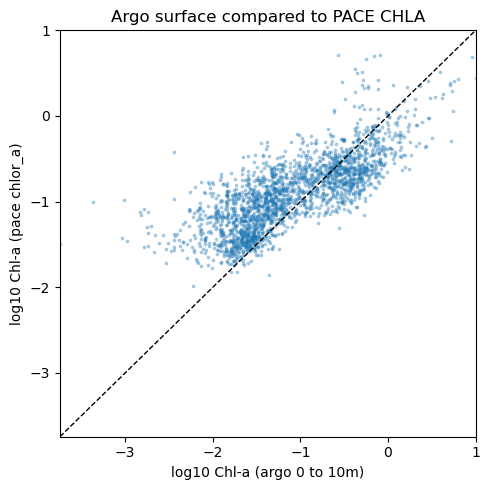

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_parquet("data/CHLA_argo_profiles_plus_PACE.parquet")
df_clean = df.dropna(subset=["CHLA_0_10"])

# Take logs (natural log; use np.log10 if you prefer log10)
y_argo = df_clean["CHLA_0_10"].values
y_pace = df_clean["pace_chlor_a"].values

# Mask: positive & finite in both
mask = (
    np.isfinite(y_argo) &
    np.isfinite(y_pace) &
    (y_argo > 0) &
    (y_pace > 0)
)

y_argo = y_argo[mask]
y_pace = y_pace[mask]

y_argo = np.log10(y_argo)
y_pace = np.log10(y_pace)

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_argo, y_pace, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_argo.min(), y_pace.min()),
    max(y_argo.max(), y_pace.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("log10 Chl-a (argo 0 to 10m)")
plt.ylabel("log10 Chl-a (pace chlor_a)")
plt.title("Argo surface compared to PACE CHLA")
plt.tight_layout()
plt.show()

## Illustrate the effect of solar hour

We can look at the bias between our in-situ and satellite derived estimates to see the effect of solar hour. Solar hour is known to be a big issue for Bio-Argo CHLA sensor and we didn't do anything to correct for that. We will correct for that indirectly by including solar hour in our Boosted Regression Tree model.

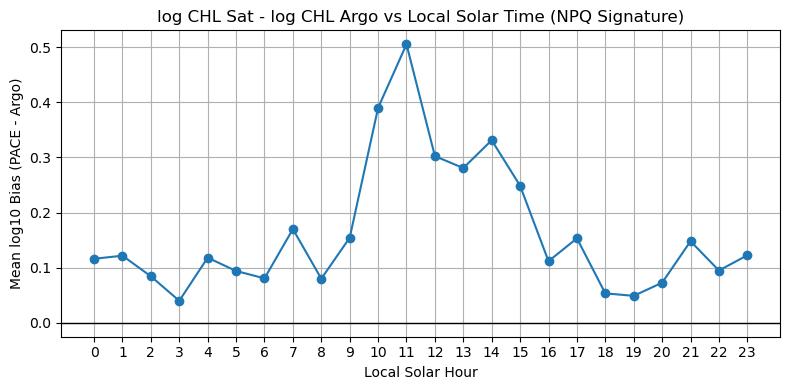

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
#  CHL bias vs local solar time
# ============================

df = pd.read_parquet("data/CHLA_argo_profiles_plus_PACE.parquet")
df = df.dropna(subset=["CHLA_0_10"])

df_bias = df.copy()

# --- Ensure datetime ---
df_bias['TIME'] = pd.to_datetime(df_bias['TIME'], utc=True, errors='coerce')

# --- Basic cleaning: drop rows missing key fields ---
df_bias = df_bias.dropna(subset=['TIME', 'LONGITUDE', 'CHLA_0_10', 'pace_chlor_a'])

# --- Remove non-positive CHL (can't take log10 of these) ---
df_bias = df_bias[(df_bias['CHLA_0_10'] > 0) & (df_bias['pace_chlor_a'] > 0)]

# --- Compute log10 CHL and bias (PACE - Argo) ---
eps = 1e-6  # tiny offset for numerical safety, but we already filtered <=0
df_bias['log_chl_argo'] = np.log10(df_bias['CHLA_0_10'] + eps)
df_bias['log_chl_sat'] = np.log10(df_bias['pace_chlor_a'] + eps)
df_bias['bias'] = df_bias['log_chl_sat'] - df_bias['log_chl_argo']

# --- Compute local solar time (approx) ---
# longitude in degrees east; 15° = 1 hour offset from UTC
df_bias['solar_hour'] = (df_bias['TIME'].dt.hour + df_bias['LONGITUDE'] / 15.0) % 24

# Bin into integer solar hours (0–23)
df_bias['solar_hour_bin'] = df_bias['solar_hour'].astype(int)

# --- Group by local solar hour and compute stats ---
bias_by_solar = df_bias.groupby('solar_hour_bin')['bias'].agg(['mean', 'median', 'std', 'count'])

#print("Bias (log10, PACE - Argo) by *local solar hour*:")
#display(bias_by_solar)

# --- Plot mean bias vs local solar hour ---
plt.figure(figsize=(8, 4))
plt.plot(bias_by_solar.index, bias_by_solar['mean'], '-o')
plt.axhline(0, color='k', lw=1)
plt.xlabel('Local Solar Hour')
plt.ylabel('Mean log10 Bias (PACE - Argo)')
plt.title('log CHL Sat - log CHL Argo vs Local Solar Time (NPQ Signature)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## Look at correlation with Kd

Kd is correlated with chlor_a so this is a bit of a repeat of the first plot.

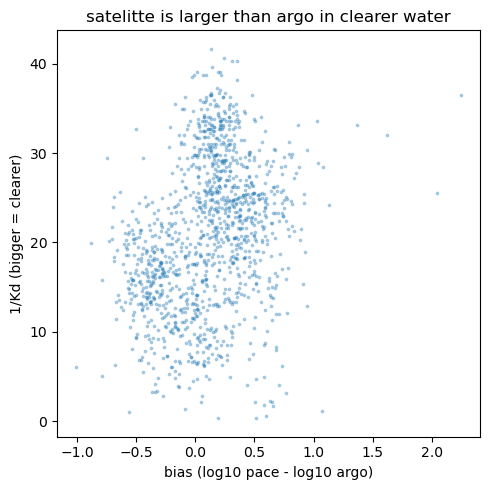

In [52]:
df = pd.read_parquet("data/CHLA_argo_profiles_plus_PACE.parquet")

df_bias = df.copy()

# --- Ensure datetime ---
df_bias['TIME'] = pd.to_datetime(df_bias['TIME'], utc=True, errors='coerce')

# --- Basic cleaning: drop rows missing key fields ---
df_bias = df_bias.dropna(subset=['TIME', 'LONGITUDE', 'CHLA_0_10', 'pace_chlor_a'])

# --- Remove non-positive CHL (can't take log10 of these) ---
df_bias = df_bias[(df_bias['CHLA_0_10'] > 0) & (df_bias['pace_chlor_a'] > 0)]

# --- Compute log10 CHL and bias (PACE - Argo) ---
eps = 1e-10  # tiny offset for numerical safety, but we already filtered <=0
df_bias['log_chl_argo'] = np.log10(df_bias['CHLA_0_10'] + eps)
df_bias['log_chl_sat'] = np.log10(df_bias['pace_chlor_a'] + eps)
df_bias['bias'] = df_bias['log_chl_sat'] - df_bias['log_chl_argo']

# --- Compute local solar time (approx) ---
# longitude in degrees east; 15° = 1 hour offset from UTC
df_bias['solar_hour'] = (df_bias['TIME'].dt.hour + df_bias['LONGITUDE'] / 15.0) % 24

# --- Remove mid day solar hour ---
df_bias = df_bias[~((df_bias['solar_hour'] > 8) & (df_bias['solar_hour'] < 16))]

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(df_bias['bias'], 1/df_bias['pace_Kd_490'], s=3, alpha=0.3)

plt.xlabel("bias (log10 pace - log10 argo)")
plt.ylabel("1/Kd (bigger = clearer)")
plt.title("satelitte is larger than argo in clearer water")
plt.tight_layout()
plt.show()